In [2]:
import eryn
from numpy import random
import numpy as np
from eryn.prior import ProbDistContainer, uniform_dist
from eryn.ensemble import EnsembleSampler
from eryn.state import State
from chainconsumer import ChainConsumer
import corner
import matplotlib.pyplot as plt
from eryn.moves import GaussianMove

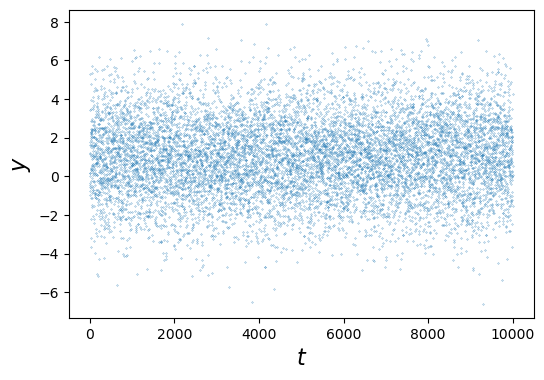

In [4]:
data_size = 10000
x = random.normal(1, 2, data_size)
t = np.arange(data_size)
fig = plt.figure(figsize=(6, 4))
plt.scatter(t, x, s=0.05)
#plt.plot([0, data_size], [1, 1], color = 'red')
#plt.plot([0, data_size], [3, 3], color = 'green')
#plt.plot([0, data_size], [-1, -1], color = 'green')
plt.ylabel(r'$y$', fontsize = 16)
plt.xlabel(r'$t$', fontsize = 16)
plt.savefig('/Users/ngalanis/VSCode Pictures/highQ/timeseries.pdf', bbox_inches='tight', dpi=600)
plt.show()

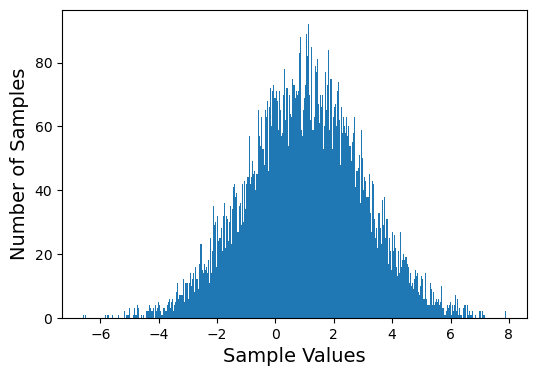

In [5]:
fig = plt.figure(figsize=(6, 4))
plt.hist(x, bins=400)
plt.xlabel('Sample Values', fontsize = 14)
plt.ylabel('Number of Samples', fontsize = 14)
plt.savefig('/Users/ngalanis/VSCode Pictures/highQ/Samples_hist.pdf', bbox_inches='tight', dpi=600)
plt.show()

In [6]:
import eryn
from numpy import random
import numpy as np
from eryn.prior import ProbDistContainer, uniform_dist
from eryn.ensemble import EnsembleSampler
from chainconsumer import ChainConsumer


def log_likelihood(pars, d):
    return -len(d) * np.log(pars[1]) - 0.5*( (d - pars[0])**2 ).sum()/pars[1]**2

x = random.normal(1, 2, 10000)  # Generate data

priors_in = {0: uniform_dist(-4, 4),
             1: uniform_dist(0.01, 4)}  # Give priors

priors = ProbDistContainer(priors_in)

#ntemps = 10
ndim = 2
nwalkers = 200

ensemble = EnsembleSampler(
    nwalkers,
    ndim,
    log_likelihood,
    priors,
    args=[x])

coords = priors.rvs(size=(nwalkers,))

burnin = 500
nsteps = 2000

out = ensemble.run_mcmc(coords, nsteps, burn = burnin, progress = True)

100%|██████████| 2000/2000 [00:06<00:00, 332.11it/s]


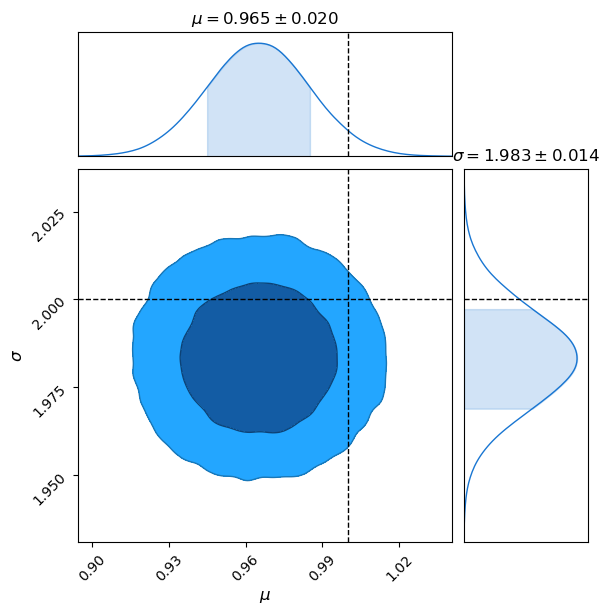

In [7]:
samples = ensemble.get_chain()['model_0'].reshape(-1, ndim)
c = ChainConsumer()
c.add_chain(samples, parameters=[r'$\mu$', r"$\sigma$"])
c.configure(label_font_size=12)
c.plotter.plot(figsize=(6,6), truth=[1, 2])
plt.savefig('/Users/ngalanis/VSCode Pictures/highQ/density plot.pdf', bbox_inches='tight', dpi=600)


In [ ]:
#c = ChainConsumer()
#c.configure()
#colors = plt.cm.magma(np.linspace(0,1, ntemps))

#for temp in range(ntemps):

    #samples = ensemble.get_chain()['model_0'][:, temp].reshape(-1, ndim)    
    #c.add_chain(samples, ["m", "s"], color=colors[temp], name="$T_{}$".format(temp))

#c.plotter.plot_distributions(figsize=(6,6), truth=[1, 2]);

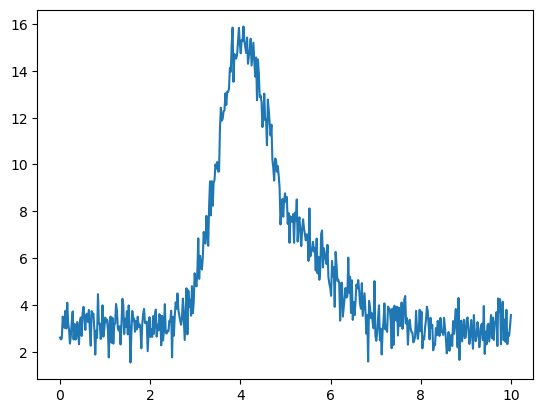

In [6]:
def gaussian(t, b, m, s):
    return b*np.exp(-0.5*(t-m)**2/s**2)


t = np.linspace(0, 10, 500)
signal = 3 + gaussian(t, 10, 4, 0.5) + gaussian(t, 4, 5, 1)
total = signal + random.normal(0, 0.6, 500)

plt.plot(t, total)
plt.show()

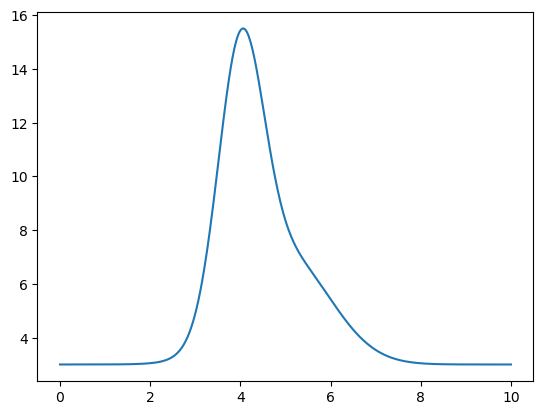

In [7]:
def gauss_model(t, a, params):
    function = np.zeros_like(t)
    if params is not None:
        for i in params:
            function = function + gaussian(t, *i)
    if a is not None:
        function = function + a[0][0]
    return function

t = np.linspace(0, 10, 500)
pars = [
    [10, 4, 0.5],
    [4, 5, 1]
]
a = [[3]]
x = gauss_model(t, a, pars)
plt.plot(t, x)
plt.show()

In [11]:
def log_likelihood(all_params, t, total, ns):
    a, params = all_params
    return -0.5*((total - gauss_model(t, a, params))**2).sum()/ns**2

branch_names = ["constant", "gauss"]

priors = {
    "constant" : {
        0: uniform_dist(0.1,5)
    },
    "gauss" : {
        0: uniform_dist(0.5,20),
        1: uniform_dist(0,10),
        2: uniform_dist(0.01,6)
    }
}


ndim = [1, 3]
nleaves_min = [0, 0]
nleaves_max = [1, 6]
nwalkers = 100
ns = 0.6
ntemps = 10


cov = {
    "constant" : np.identity(ndim[0])*0.001,
    "gauss" : np.identity(ndim[1])*0.001
}

moves = GaussianMove(cov)


ensemble = EnsembleSampler(
    nwalkers,
    ndim,
    log_likelihood,
    priors,
    args = [t, total, ns],
    tempering_kwargs = dict(ntemps=ntemps),
    nbranches = len(branch_names),
    branch_names = branch_names,
    nleaves_max = nleaves_max,
    nleaves_min = nleaves_min,
    moves = moves,
    rj_moves=True)

In [12]:
coords = {
    name : np.zeros((ntemps, nwalkers, leaves, dims)) for name, leaves, dims in zip(branch_names, nleaves_max, ndim)
}

for name, leaves, dims in zip(branch_names, nleaves_max, ndim):
    for d in range(dims):
        coords[name][:, :, :, d] = priors[name][d].rvs(size=(ntemps, nwalkers, leaves))

inds = {
    "constant" : np.ones(shape=(ntemps, nwalkers, nleaves_max[0]), dtype=bool),
    "gauss" : np.random.randint(low=0, high=2, size=(ntemps, nwalkers, nleaves_max[1]), dtype=bool)
}

state = State(coords, inds=inds)
nsteps = 5000

In [13]:
out = ensemble.run_mcmc(state, nsteps, burn=1000, progress=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [02:47<00:00, 29.86it/s]


Text(0.5, 0, 'Order $k$ of model')

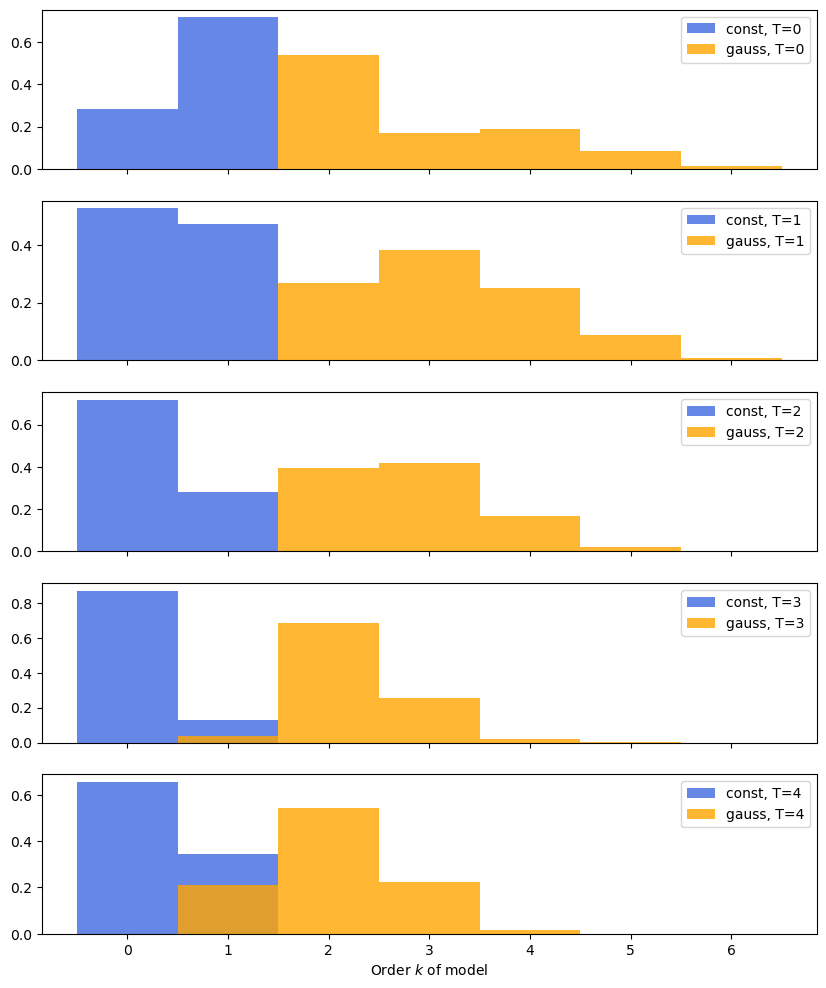

In [14]:
nleaves_const = ensemble.get_nleaves()['constant']
nleaves_gauss = ensemble.get_nleaves()['gauss']
bns = (
    np.arange(0, nleaves_max[1] + 2) - 0.5
)  # Just to make it pretty and center the bins

fig, ax = plt.subplots(ntemps, 1, sharex=True)
fig.set_size_inches(10, 12)
for temp, ax_t in enumerate(ax):
    ax_t.hist(nleaves_const[:, temp].flatten(), lw=4, bins=bns, color='royalblue', alpha=.8, density=True, label="const, T={}".format(temp))
    ax_t.hist(nleaves_gauss[:, temp].flatten(), lw=4, bins=bns,color='orange', alpha=.8, label="gauss, T={}".format(temp), density=True)
    ax_t.legend(loc="upper right")
ax_t.set_xlabel("Order $k$ of model")

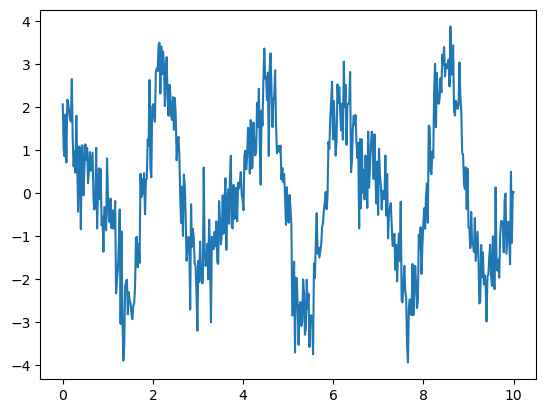

In [36]:
def sin(t, a, w, phi):
    return a*np.sin(w*t+phi)

def sins(t, pars):
    function = np.zeros_like(t)
    for par in pars:
        function = function + sin(t, *par)
    return function

pars=[[1, 5, np.pi],[2, 3, np.pi/3]]
ns = 0.6

t = np.linspace(0, 10, 500)
x = sins(t, pars) + random.normal(0, ns, 500)

plt.plot(t, x)
plt.show()

In [33]:
def log_likelihood(pars, t, x, nsigma):
    l = -0.5*( (x - sins(t, pars))**2 ).sum()/nsigma**2
    return l


branch_names = ["sinus"]
ndim = 3
nwalkers = 200
nleaves_min = 0
nleaves_max = 6
ntemps = 10

priors = {
    "sinus" : {
            0 : uniform_dist(0,10),
            1 : uniform_dist(np.pi/10, 2*np.pi),
            2 : uniform_dist(0, 2*np.pi)
        }
    }

cov = {"sinus" : np.identity(ndim)*0.01}
moves = GaussianMove(cov)


ensemble = EnsembleSampler(
                nwalkers,
                ndim,
                log_likelihood,
                priors,
                args = [t, x, ns],
                tempering_kwargs = dict(ntemps=ntemps),
                nbranches = len(branch_names),
                branch_names = branch_names,
                nleaves_max = nleaves_max,
                nleaves_min = nleaves_min,
                moves = moves,
                rj_moves = True)

In [138]:
coords = {"sinus": np.zeros((ntemps, nwalkers, nleaves_max, ndim))}

for d in range(ndim):
        coords["sinus"][:, :, :, d] = priors["sinus"][d].rvs(size=(ntemps, nwalkers, nleaves_max))

inds = {"sinus": np.random.randint(low=0, high=2, size=(ntemps, nwalkers, nleaves_max), dtype=bool)}

state = State(coords, inds = inds)
nsteps = 2000

In [139]:
out = ensemble.run_mcmc(state, nsteps, burn=500, progress=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:59<00:00, 11.12it/s]


Text(0.5, 0, 'Order $k$ of model')

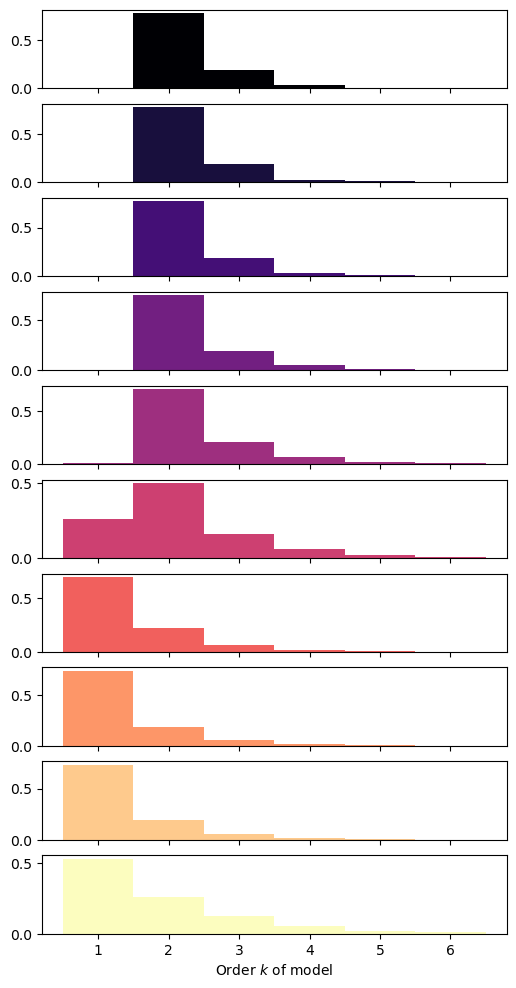

In [140]:
nleaves = ensemble.get_nleaves()['sinus']
bns = (
    np.arange(1, nleaves_max + 2) - 0.5
)  # Just to make it pretty and center the bins

colors = plt.cm.magma(np.linspace(0,1, ntemps))

fig, ax = plt.subplots(ntemps, 1, sharex=True)
fig.set_size_inches(6, 12)
for temp, ax_t in enumerate(ax):
    ax_t.hist(nleaves[:, temp].flatten(), bins=bns, color=colors[temp], density=True)
ax_t.set_xlabel("Order $k$ of model")

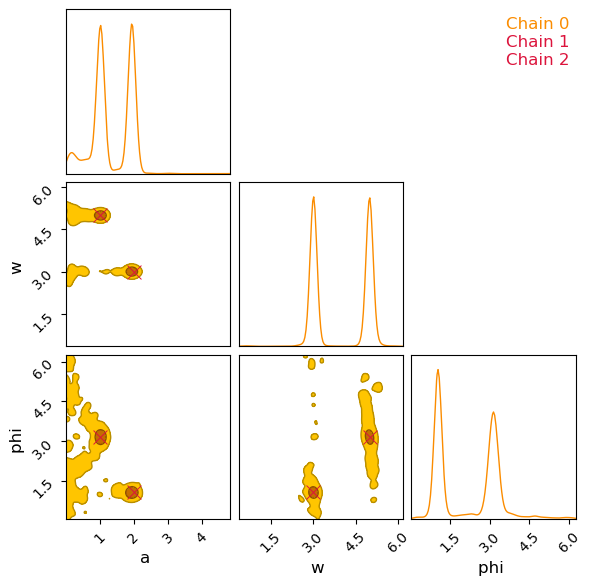

In [142]:
samples = ensemble.get_chain()['sinus'][:, 0].reshape(-1, ndim)

# same as ensemble.get_chain()['gauss'][ensemble.get_inds()['gauss']]
samples = samples[~np.isnan(samples[:, 0])]

true_params = [[1, 5, np.pi],[2, 3, np.pi/3]]


param_names = ['a', 'w', 'phi']

c = ChainConsumer()
c.add_chain(samples, parameters=param_names, color='orange')
c.configure()

for i in range(len(true_params)):
    c.add_marker(true_params[i], parameters=param_names, marker_style="x", marker_size=100, color='#DC143C')

c.plotter.plot(figsize=(6,6));

In [43]:
def sins(t, pars):
    function = sin(t, *pars[0:3]) + sin(t, *pars[3:6])
    return function

def log_likelihood(pars, t, x, nsigma):
    l = -0.5*( (x - sins(t, pars))**2 ).sum()/nsigma**2
    return l


ndim = 6
nwalkers = 20
ntemps = 10

priors_in = {
            0 : uniform_dist(0,10),
            1 : uniform_dist(np.pi/10, 2*np.pi),
            2 : uniform_dist(0, 2*np.pi),
            3 : uniform_dist(0,10),
            4 : uniform_dist(np.pi/10, 2*np.pi),
            5 : uniform_dist(0, 2*np.pi)
    }

priors = ProbDistContainer(priors_in)


ensemble = EnsembleSampler(
                nwalkers,
                ndim,
                log_likelihood,
                priors,
                args = [t, x, ns],
                tempering_kwargs = dict(ntemps=ntemps)
            )

coords = priors.rvs(size=(ntemps,nwalkers))
nsteps = 2000

out = ensemble.run_mcmc(coords, nsteps, burn=500, progress=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:06<00:00, 288.38it/s]


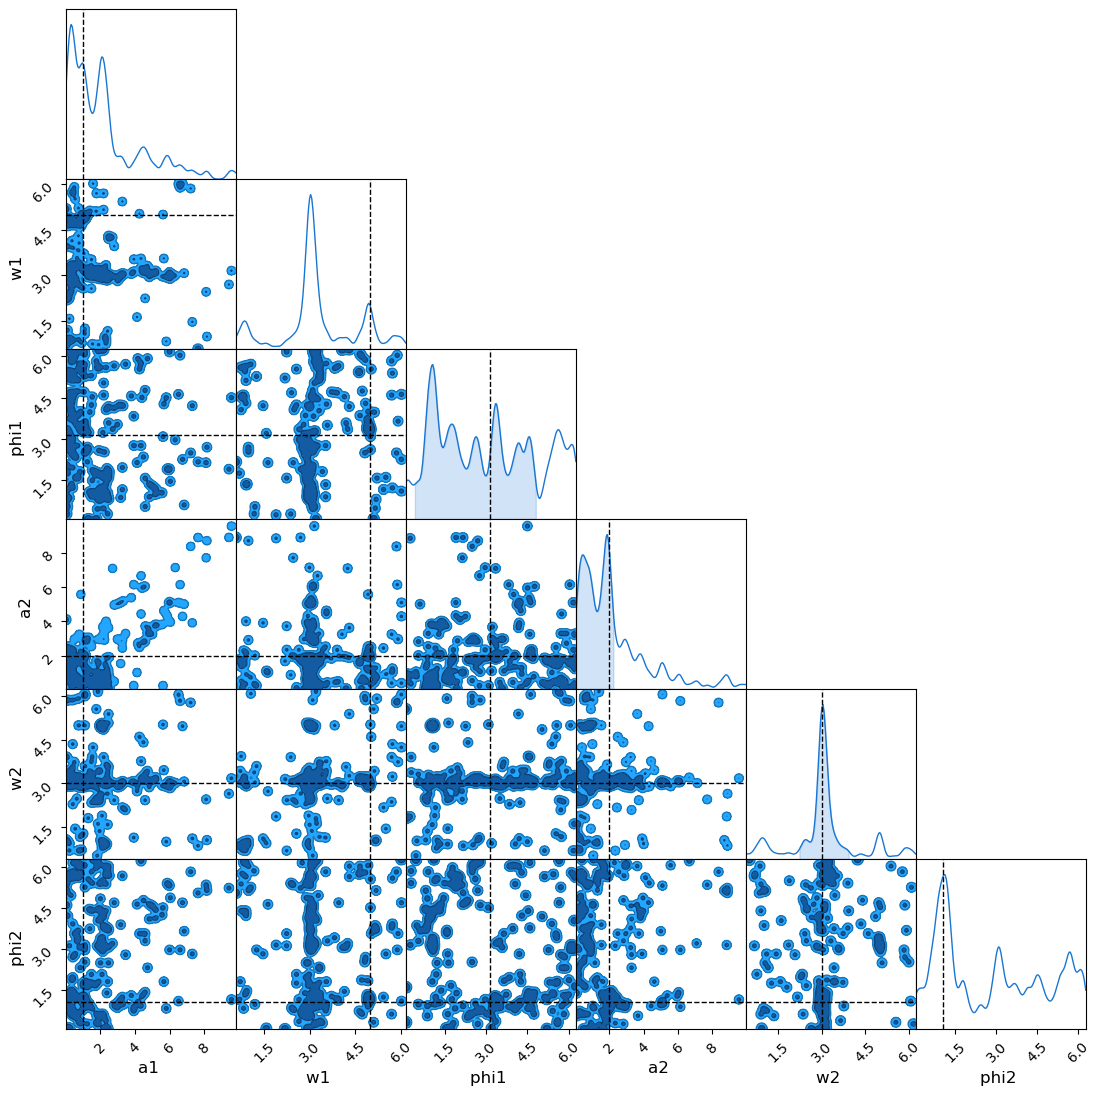

In [44]:
samples = ensemble.get_chain()['model_0'][0].reshape(-1, ndim)
c = ChainConsumer()
c.add_chain(samples, parameters=["a1", "w1", "phi1", "a2", "w2", "phi2"])
c.configure()
c.plotter.plot(figsize=(12,12), truth=[1, 5, np.pi, 2, 3, np.pi/3]);

In [2]:
help(EnsembleSampler)

Help on class EnsembleSampler in module eryn.ensemble:

class EnsembleSampler(builtins.object)
 |  EnsembleSampler(nwalkers, ndims, log_like_fn, priors, provide_groups=False, provide_supplimental=False, tempering_kwargs={}, branch_names=None, nbranches=1, nleaves_max=1, nleaves_min=1, pool=None, moves=None, rj_moves=None, dr_moves=None, dr_max_iter=5, args=None, kwargs=None, backend=None, vectorize=False, blobs_dtype=None, plot_iterations=-1, plot_generator=None, plot_name=None, periodic=None, update_fn=None, update_iterations=-1, stopping_fn=None, stopping_iterations=-1, fill_zero_leaves_val=-1e+300, num_repeats_in_model=1, num_repeats_rj=1, verbose=False, info={})
 |  
 |  An ensemble MCMC sampler
 |  
 |  The class controls the entire sampling run. It can handle
 |  everything from a basic non-tempered MCMC to a parallel-tempered,
 |  global fit containing multiple branches (models) and a variable
 |  number of leaves (sources) per branch. (# TODO: add link to tree explainer)
 |  
 

In [57]:
p = [[1, 2],[3, 4],[5, 6]]
np.shape(p)

(3, 2)

In [72]:
p2 = [[1]]
np.shape(p2)

(1, 1)

In [69]:
p2=np.array(p2).flatten()

In [75]:
np.linspace(0,10,11)+p2[0]

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.])

In [77]:
p2 = [[1]]
p2[0][0]

1

In [110]:
np.random.randint(0,1,10, dtype=bool)

array([False, False, False, False, False, False, False, False, False,
       False])

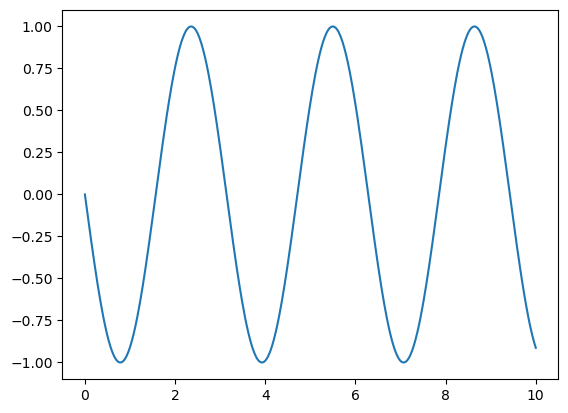

In [147]:
pars = [1, 2, np.pi, 2, 5, 0]
plt.plot(t, sin(t, *pars[0:3]))

(1e-06, 0.049999999999999996)

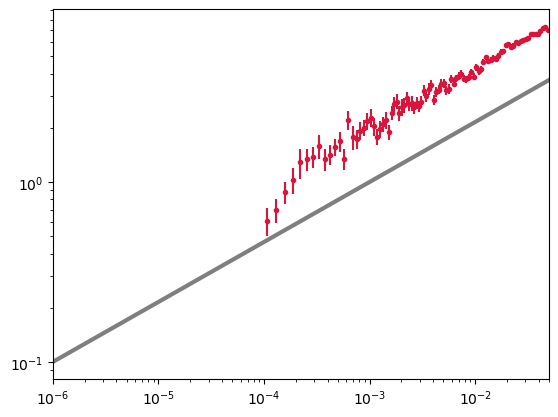

In [51]:
from spectral import genTimeSeriesFromPSD, lpsd, welchpsd

def powerlaw(f, omega, n):
    return omega*f**n

dt = 10
T_obs = 1e6
samplingf = 1/dt
df = 1/T_obs
Ndata = int(T_obs/dt)
t = np.arange(0, T_obs, dt)

if (Ndata % 2)==0:              
    nfft = int((Ndata/2)+1)
else:
    nfft = int((Ndata+1)/2)

F = df*nfft                 
f = np.arange(0, F, df)

true_pars = [10, 1/3]

S = powerlaw(f, *true_pars)

data = genTimeSeriesFromPSD(S, samplingf)

f0 = 1e-4
f1 = 5e-2

fl, Sl, Sle, _, Kavs = lpsd(data, samplingf, Kdes=100, Jdes=200, flims=[f0, f1], win='nuttall4b', winalpha=0., olap=0.0, order=0, errrype='std', DOPLOT=False, VERBOSE=False)
errs = [np.absolute(Sle[0]), np.absolute(Sle[1])]

plt.loglog(f, S, alpha=0.5, color='k', linewidth=3, label='My PSD theoretical model')
plt.errorbar(fl, np.abs(Sl), yerr=errs, fmt='.', label='logPSD', color='crimson')
plt.xlim(f[1], f[-1])

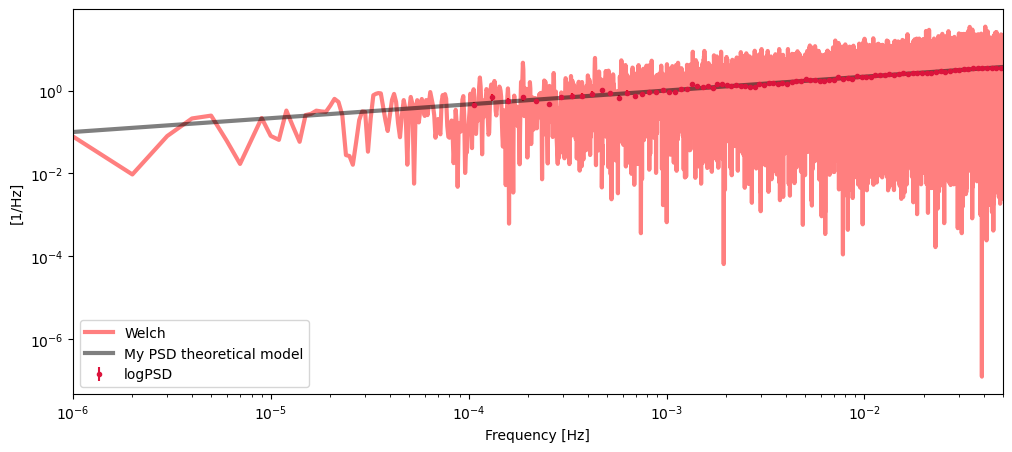

In [3]:
from spectral import genTimeSeriesFromPSD, lpsd, welchpsd

def powerlaw(f):
    return 10*f**(1/3)

Tobs  = 1e6                     # Duration of data 
dt    = 10                      # Delta-t [s]
fs    = 1/dt                    # Sampling frequency
Ndata = int(Tobs/dt)            # Number of data points
tvec  = np.arange(0, Tobs, dt)  # Get the time vector
df    = 1.0/Tobs                # Define Delta-f

if (Ndata % 2)==0:              # Get the number of requencies
    nfft = int((Ndata/2)+1)
else:
    nfft = int((Ndata+1)/2)

F     = df*nfft                 # make the positive frequency vector
fvec  = np.arange(0, F, df)

# Get the PSD of the noise using hte model above
Sn = powerlaw(fvec)
Sn[0]=0

from scipy.stats import chi2, norm

### Gererate time series from a PSD spectrum
def genTimeSeriesFromPSD2(S,fs):
    """ genTimeSeriesFromPSD (S,fs)

    A simple function to generate time series from a given *one-sided* power spectrum
    via iFFT. It draws the amplitudes from a chi2 distribution, while it asigns
    a random phase between [-2*pi, 2*pi].

    NK 2019
    """

    N    = 2*(len(S)-1)
    Ak   = np.sqrt(N*S/2*fs)             # Take the sqrt of the amplitude
    Ak   = np.append(Ak, Ak[1:-1][::-1]) # make two-sided
    rphi = np.zeros(N)

    rphi[1:int(N/2)-1]   = 2*np.pi*np.random.uniform(0, 1, int(N/2)-2)  # First half
    rphi[int(N/2)]       = 2*np.pi*round(np.random.uniform(0, 1))       # mid point
    rphi[int(N/2+1):N-1] = -rphi[1:int(N/2)-1][::-1]                    # reflected half

    X = Ak*np.sqrt(chi2.rvs(2, size=N)/2) * np.exp(1j * rphi)

    return np.fft.irfft(X,n=int(N)) # return Inverse FFT



my_data = genTimeSeriesFromPSD2(Sn,fs) # I divide by two because the function assumes the 2-sided spectrum

f0 = 1e-4
f1 = 5e-2

fl, Sl, Sle, _, Kavs = lpsd(my_data, fs, Kdes=100, Jdes=200, flims=[f0, f1], win='nuttall4b', winalpha=0., olap=0.0, order=0, errrype='std', DOPLOT=False, VERBOSE=False)
errs = [np.absolute(Sle[0]), np.absolute(Sle[1])]

plt.figure(figsize=(12,5))
plt.errorbar(fl, np.absolute(Sl), yerr=errs, fmt='.', label='logPSD', color='crimson')

from spectral import welchpsd
f20, S20 = welchpsd(my_data, fs, len(my_data), win='nuttall4c')
plt.loglog(f20[1:], S20[1:], alpha=0.5, color='r', linewidth=3, label='Welch')

plt.loglog(fvec[1:], Sn[1:], alpha=0.5, color='k', linewidth=3, label='My PSD theoretical model')
plt.xlim(fvec[1], fvec[-1])
plt.ylabel('[1/Hz]')
plt.xlabel('Frequency [Hz]')
plt.legend(loc='lower left')

In [86]:
a = np.array([[1,2],[5,6],[3,4]])
a[:,0]

array([1, 5, 3])

In [74]:
for i in a:
    print(i)

[1 2]
[5 6]
[3 4]


In [78]:
a = np.array([1,2,3])
list(a) + [1]

[1, 2, 3, 1]

In [82]:
a = [[1,2]]
a[0][1]

2

In [108]:
a = np.array([1,3,6,36,8,2,5])
print(a[np.argsort(a)])

[ 1  2  3  5  6  8 36]


In [114]:
a = np.array([[1,8],[5,1],[3,4]])
a[a[:,0].argsort()]

array([[1, 8],
       [3, 4],
       [5, 1]])

In [115]:
a = [1,2,5,2,3]
np.diff(a)

array([ 1,  3, -3,  1])

In [127]:
np.exp(1)

2.718281828459045

In [191]:
a = np.ones(shape=(3, 4, 2), dtype = int)
print(a)

[[[1 1]
  [1 1]
  [1 1]
  [1 1]]

 [[1 1]
  [1 1]
  [1 1]
  [1 1]]

 [[1 1]
  [1 1]
  [1 1]
  [1 1]]]


In [192]:
b = np.random.randint(low=0, high=2, size=(3, 4, 3), dtype = int)
print(b)

[[[1 0 1]
  [0 1 0]
  [1 0 0]
  [1 0 0]]

 [[1 0 0]
  [1 0 0]
  [0 0 0]
  [1 0 1]]

 [[0 1 1]
  [0 0 0]
  [0 0 0]
  [0 0 0]]]


In [193]:
c = np.concatenate((a, b), axis = 2)
print(c.shape)

(3, 4, 5)
